In [2]:
import numpy as np
import matplotlib.pyplot as plt

Data Model: data = signal+noise    
signal           = Ax+mu  
x is a random number drawn from a standard normal distribution, < x >=0, <x^2>=1    
the noise is Gaussian with mean =< noise >=0 and variance = < ( x-< x >)**2 >=sigma^2

A and mu depend on the parameters a,b. a and b are the parameters we are interested in inferring.

In [3]:
#get A as a function of a,b
def get_A(a,b,dim=1):
    A = a**2*np.ones((dim,dim))+b/2.
    return A

In [4]:
#get mu as a function of a,b
def get_mu(a,b, dim=1):
    mu = a**3/np.exp(b)*np.ones(dim)
    return mu

Fiducial Parameters (this is the underlying truth)

In [5]:
a_0=2; b_0=0.5

In [6]:
A_0  = get_A(a_0,b_0)
mu_0 = get_mu(a_0, b_0)

Noise level

In [7]:
sigma = 0.1

In [8]:
def generate_noise(sigma,dim=1,nsamples=100,rand_seed=None):
    np.random.seed(rand_seed)
    noise = np.random.randn(nsamples,dim)*sigma
    return noise

In [9]:
def generate_signal(A,mu,sigma,dim=1, nsamples=100,rand_seed=None):
    np.random.seed(rand_seed)
    x      = np.random.randn(nsamples,dim)
    signal = A*x+mu
    return signal

In [10]:
def generate_data(A,mu,sigma,dim,nsamples,rand_seed=None):
    
    signal = generate_signal(A,mu,sigma,dim,nsamples,rand_seed)
    noise  = generate_noise(sigma,dim,nsamples,rand_seed)
    
    data   = signal+noise
    
    return data

fiducial data (that's the assumed truth)

In [11]:
fid_data = generate_data(A_0,mu_0,sigma,dim=1, nsamples=1000,rand_seed=None)

In [12]:
def Gaussian(x,Mu,Sigma):
    return 1/np.sqrt(np.pi*2.)/Sigma*np.exp(-0.5*(x-Mu)**2/Sigma**2)

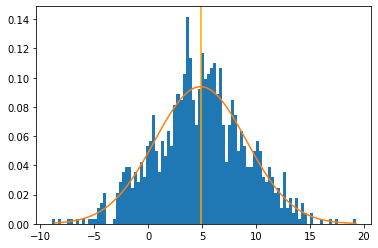

In [13]:
_, bins,_ = plt.hist(fid_data, density=True,bins=100)
plt.axvline(mu_0,color='orange')
delta = np.diff(bins) 
bins  = bins[0:-1]+delta
plt.plot(bins,np.squeeze(Gaussian(bins,mu_0,(A_0**2+sigma**2)**(0.5))))
plt.show()

#### Fit P(A|d) by Fisher Analysis

In [14]:
def get_Gaussian(mu,Sigma):
    
    def Gaussian(x):
        return 1/np.sqrt((2.*np.pi))/Sigma*np.exp(-0.5*(x-mu)**2/Sigma**2)
    
    return Gaussian

In [104]:
def get_Sigma(params):
    a,b = params
    return a**2+1

def get_mu(params):
    a,b = params
    return (b-2)**2

In [105]:
def data_probability(params,data):
    Sigma = get_Sigma(params)
    mu    = get_mu(params)
    prob  = get_Gaussian(mu, Sigma)
    return prob(data)

In [226]:
def finite_diff(params,func):
    delta_params = np.asarray([0.001,0.001])
    derivative = (func(params+delta_params)-func(params-delta_params))/(2*delta_params)
    return derivative

In [227]:
from functools import partial

In [228]:
def generate_data(params):
    Sigma = get_Sigma(params)
    mu    = get_mu(params)
    data  = Sigma*np.random.randn(1)+mu
    return data

In [229]:
true_params = [1.5,2]

In [310]:
data = generate_data(true_params)
print(data)
#to make it a hard problem, set data to 3.71343085
#data = 3.71343085
# to make it an easy problem, set data to -2.08261133

[-7.65952663]


In [311]:
p_of_params = partial(data_probability, data=data)
deriv       = partial(finite_diff,func=p_of_params)
# if it's not too much work: maybe you can try to replace the finite differencing operator by it's analytical derivative?

In [312]:
from scipy.optimize import fsolve, minimize

In [313]:
params_init = [1.,2.]

In [314]:
# this solver is not working well, as you can see
output= fsolve(deriv,params_init,full_output=True,maxfev=1000,xtol=1e-10)
print(output)
best_params= output[0]
print(best_params)

(array([0.90268926, 9.69388583]), {'nfev': 1000, 'fjac': array([[-0.70710678, -0.70710678],
       [-0.70710678,  0.70710678]]), 'r': array([ 3.27416458e-284,  8.04570754e-284, -3.34263791e-304]), 'qtf': array([-1.65748383e-292,  6.67515272e-308]), 'fvec': array([5.68985824e-293, 5.68985824e-293])}, 2, 'The number of calls to function has reached maxfev = 1000.')
[0.90268926 9.69388583]


In [315]:
# here we sample the probability distribution on a grid
# (I think that's what Lister tried to do, or maybe even did?)
a_ = np.linspace(-5,5,100)
b_ = np.linspace(-2,5,100)
a_, b_ = np.meshgrid(a_,b_)
p  = p_of_params([a_,b_])


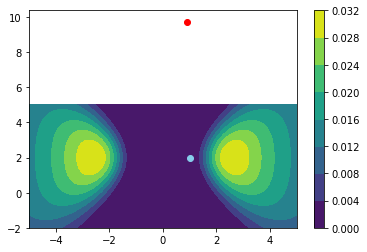

In [316]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(a_, b_, p)
plt.scatter(best_params[0],best_params[1],color='red')
plt.scatter(params_init[0],params_init[1],color='skyblue')
fig.colorbar(cp)

In [317]:
#let's switch to minimization instead. This is the Nelder-Mead algorithm
result = minimize(lambda params: -p_of_params(params),params_init, method='Nelder-Mead')
print(result)
best_params=result['x']

 final_simplex: (array([[2.58062186, 2.00005914],
       [2.58052859, 1.99997961],
       [2.58054624, 2.0000969 ]]), array([-0.03159082, -0.03159082, -0.03159082]))
           fun: -0.03159081963698711
       message: 'Optimization terminated successfully.'
          nfev: 77
           nit: 40
        status: 0
       success: True
             x: array([2.58062186, 2.00005914])


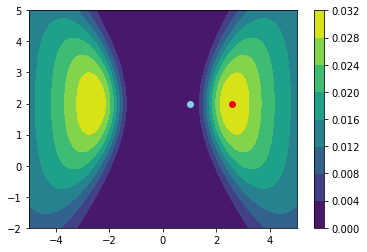

In [318]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(a_, b_, p)
plt.scatter(best_params[0],best_params[1],color='red')
plt.scatter(params_init[0],params_init[1],color='skyblue')
fig.colorbar(cp)
## -> it works very well

In [319]:
#let's try another algorithm
result = minimize(lambda params: -p_of_params(params),params_init, jac=lambda params: -deriv(params), method='L-BFGS-B', options=dict(gtol=1e-40,ftol=1e-40))
print(result)
best_params=result['x']
#it get's stuck 

      fun: array([-0.02163483])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0., -0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 16
      nit: 7
   status: 0
  success: True
        x: array([2.53683109, 3.53683109])


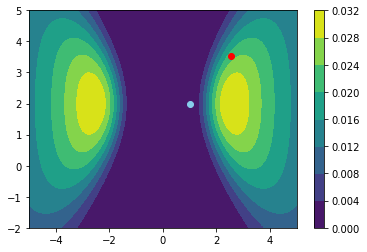

In [320]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(a_, b_, p)
plt.scatter(best_params[0],best_params[1],color='red')
plt.scatter(params_init[0],params_init[1],color='skyblue')
fig.colorbar(cp)

In [321]:
#let's try another algorithm
result = minimize(lambda params: -p_of_params(params),params_init, jac=lambda params: -deriv(params), method='Powell')
print(result)
best_params=result['x']

   direc: array([[0.00000000e+00, 1.00000000e+00],
       [2.44131089e-05, 3.12836529e-16]])
     fun: array(-0.03159082)
 message: 'Optimization terminated successfully.'
    nfev: 79
     nit: 2
  status: 0
 success: True
       x: array([2.58060588, 2.        ])


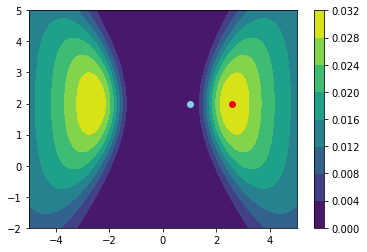

In [322]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(a_, b_, p)
plt.scatter(best_params[0],best_params[1],color='red')
plt.scatter(params_init[0],params_init[1],color='skyblue')
#fig.colorbar(cp)

In [330]:
### explore different starting values
#let's try another algorithm
result = minimize(lambda params: -p_of_params(params),params_init, jac=lambda params: -deriv(params), method='CG')
print(result)
best_params=result['x']

params_init_2=[3,3]
#let's try another algorithm
result = minimize(lambda params: -p_of_params(params),params_init_2, jac=lambda params: -deriv(params), method='CG')
print(result)
best_params2=result['x']
#it get's stuck and tells us so

     fun: array([-0.02101414])
     jac: array([0.0038605, 0.0038605])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 33
     nit: 1
    njev: 21
  status: 2
 success: False
       x: array([2.82366548, 3.82366548])
     fun: -0.03035250312742422
     jac: array([3.3131742e-06, 3.3131742e-06])
 message: 'Optimization terminated successfully.'
    nfev: 26
     nit: 5
    njev: 26
  status: 0
 success: True
       x: array([2.48254563, 2.48254563])


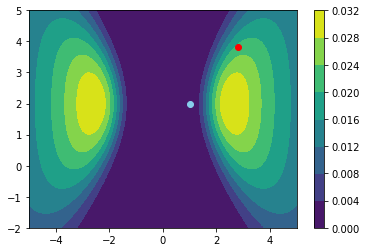

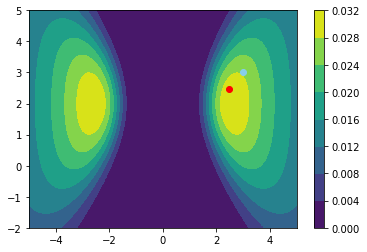

In [333]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(a_, b_, p)
plt.scatter(best_params[0],best_params[1],color='red')
plt.scatter(params_init[0],params_init[1],color='skyblue')
fig.colorbar(cp)
fig,ax=plt.subplots(1,1)
cp = ax.contourf(a_, b_, p)
plt.scatter(best_params2[0],best_params2[1],color='red')
plt.scatter(params_init_2[0],params_init_2[1],color='skyblue')
fig.colorbar(cp)

Can you try other algorithms? :) 
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
Some of them require a Hessian - you might already have a finite differencing function for Hessians. (See also next question)
Try to find out what these different algorithms do differently.

Can you compute the Fisher information from finite differencing and plot the Gaussian that we get for P(A) from the Fisher analysis?